In [2]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/katrin/Documents/gammapy/gammapy/__init__.py'>


In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}
spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : XAMJv9t4 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralM

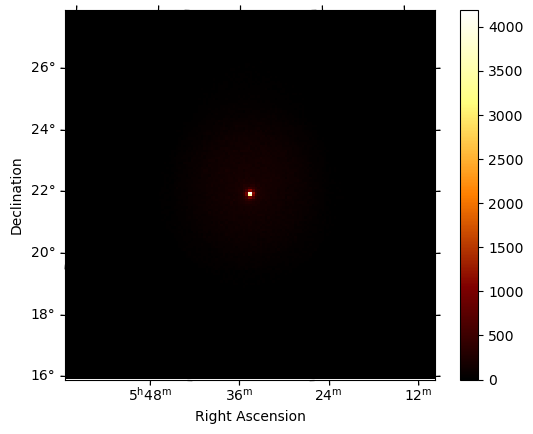

In [23]:
import json
with open("config.json") as json_data_file:
    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]

models = Models.read(f"{path_crab}/standard_model.yml")
dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')

dataset_load = dataset_load.downsample(4)
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models([source_model])

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Asimov Cases

In [5]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.015
tilt_pos =  0.015
tilt_cor = 0

print(tilt_neg)

-0.015


In [6]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        rnd = False)
dataset_cor_N = sys_d_cor.create_dataset_N()

sys_d_neg = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        rnd = False)
dataset_neg_N = sys_d_neg.create_dataset_N()

sys_d_pos = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_pos, 
                        tilt = tilt_pos,
                        rnd = False)
dataset_pos_N = sys_d_pos.create_dataset_N()

zero = 1e-24
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift_pos**2, 1/tilt_pos**2, 1/zero**2, 1/zero**2])


dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]



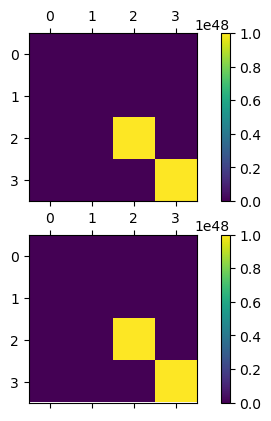

In [7]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

[]

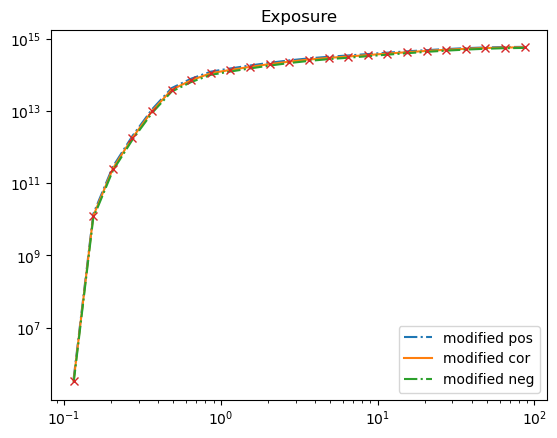

In [8]:
e_bins = dataset_cor_N.geoms['geom'].axes[0].center.value
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

plt.plot(e_bins,sum_e(dataset_pos_N.exposure.data ), label = 'modified pos', linestyle='-.')
plt.plot(e_bins,sum_e(dataset_cor_N.exposure.data ), label = 'modified cor')
plt.plot(e_bins,sum_e(dataset_neg_N.exposure.data ), label = 'modified neg', linestyle='-.')

plt.plot(e_bins,sum_e(dataset_cor_N.npred_exposure().data ), 'x')
plt.title("Exposure")

plt.legend()
plt.loglog()

[]

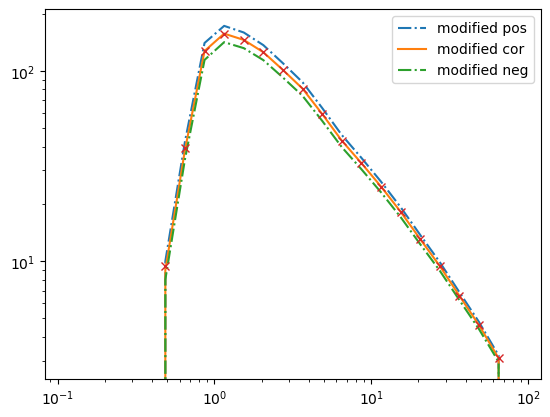

In [9]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

plt.plot(e_bins, sum_e(dataset_pos_N.npred_signal().data ), label = 'modified pos', linestyle='-.')
plt.plot(e_bins, sum_e(dataset_cor_N.npred_signal().data ), label = 'modified cor')
plt.plot(e_bins, sum_e(dataset_neg_N.npred_signal().data ), label = 'modified neg', linestyle='-.')

plt.plot(e_bins, sum_e((dataset_pos_N.counts- dataset_pos_N.background).data ), 'x')

plt.legend()
plt.loglog()

[]

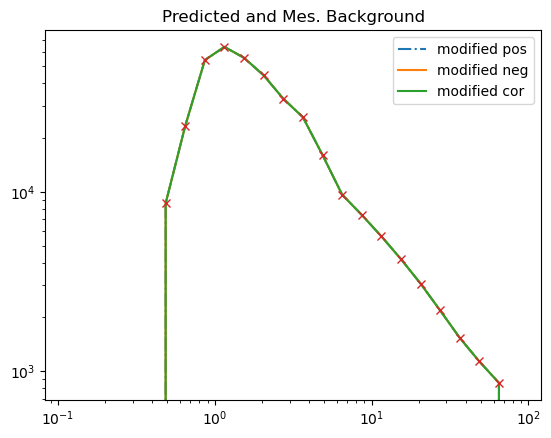

In [10]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

plt.plot(e_bins, sum_e(dataset_pos_N.npred_background().data ), label = 'modified pos', linestyle='-.')
plt.plot(e_bins, sum_e(dataset_neg_N.npred_background().data ), label = 'modified neg')
plt.plot(e_bins, sum_e(dataset_cor_N.npred_background().data ), label = 'modified cor')

plt.plot(e_bins, sum_e((dataset_pos_N.background).data ), 'x')
plt.title("Predicted and Mes. Background")

plt.legend()
plt.loglog()

In [11]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.backend = "minuit"
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run(dataset_cor_N)
        
print("neg")
fit_neg = Fit(store_trace=False)
fit_neg.backend = "minuit"
fit_neg.optimize_opts = minuit_opts
result_neg = fit_neg.run(dataset_neg_N)

print("pos")
fit_pos = Fit(store_trace=False)
fit_pos.backend = "minuit"
fit_pos.optimize_opts = minuit_opts
result_pos = fit_pos.run(dataset_pos_N)

# deleted cov


corr
neg
pos
CPU times: user 4min 42s, sys: 24.6 s, total: 5min 6s
Wall time: 5min 6s


In [12]:
print(dataset_pos_N)

MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.93
  Predicted background counts     : 360330.29
  Predicted excess counts         : 1003.64

  Exposure min                    : 2.36e-01 m2 s
  Exposure max                    : 2.51e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.08

  Number of models                : 3 
  Number of parameters            : 16
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
  

In [13]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
amplitudes_N = []
indices_N = []
norms_N = []
tilts_N = []


m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
value = dataset_asimov.background_model.parameters['tilt'].value 
error = dataset_asimov.background_model.parameters['tilt'].error
tilts_N.append((value, error))

for i,d in enumerate(datasets_short):
    m = d.models[0]
    
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))

    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    norms_N.append((value, error))

    value = d.background_model.parameters['tilt'].value 
    error = d.background_model.parameters['tilt'].error
    tilts_N.append((value, error))


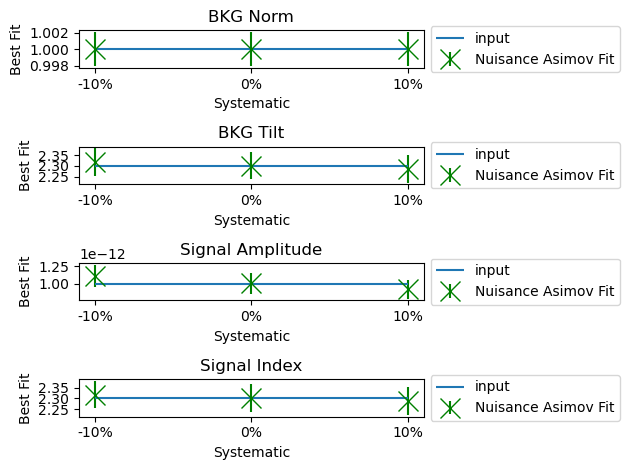

In [14]:
fig, axs = plt.subplots(4,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")


for i, a in enumerate(indices_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( indices_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[3].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    


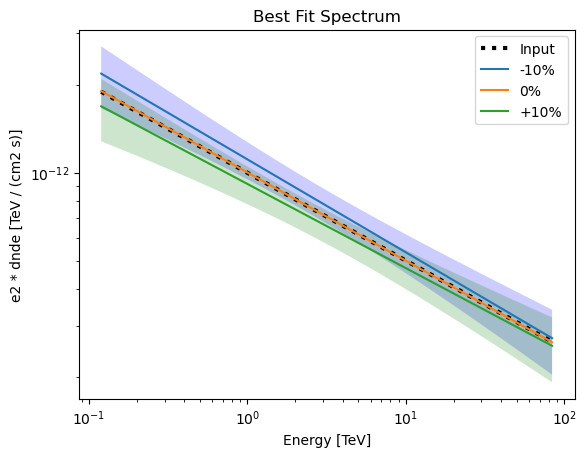

In [15]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

0.0023885789233769874 0.10833042290143291
-7.628148885332292e-05 0.10867086704251451
-0.00208070188344808 0.10931283182679884
8.822301744474152e-06 0.014909830351960163
3.0012842732196403e-06 0.014910764202297528
-4.9583591930346626e-05 0.014909668213121747
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


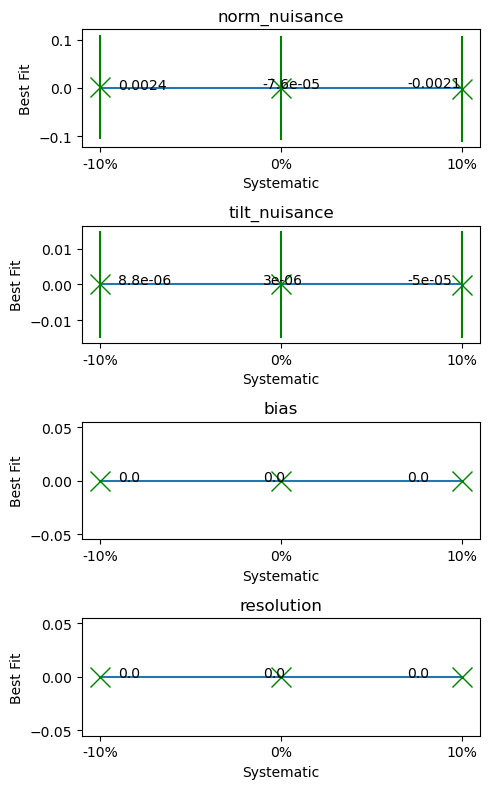

In [16]:
n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
if n_nui ==1:
    a = [a]
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
        value = d.models[-1].parameters[par_name].value
        error = d.models[-1].parameters[par_name].error
        print(value, error)

        a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                       label = label)
        a[j].text(iss[i],-value, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")

    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

## Comparison

In [17]:

with open('data/1_norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_tilts.yaml') as file:
    tilts = yaml.load( file, Loader=yaml.FullLoader)

In [18]:
params_N = [amplitudes_N, indices_N, norms_N, tilts_N]
params = [amplitudes, indices, norms, tilts]
names = ['amplitude', 'index', 'norm', 'tilt']

for i in range(len(names)):
    print('====')
    print("best fit " + names[i])
    print('====')
    print('Input')  
    value = params_N[i][0][0] 
    error = params_N[i][0][1]
    print(f' {value} pm {error}')
    for j,d in enumerate(datasets_short):
        if names[i] =="amplitude":
            weight = 1e12
        else:
            weight = 1
        value = params_N[i][1:][j][0]  * weight
        error = params_N[i][1:][j][1] * weight
        print(f' {value:10f} +- {error:10f}')
        value = params[i][1:][j][0]  * weight
        error = params[i][1:][j][1] * weight
        print(f'({value:10f} +- {error:10f})')
    print()

====
best fit amplitude
====
Input
 1e-12 pm 0.0
   1.111248 +-   0.161846
(  1.110531 +-   0.099731)
   1.002380 +-   0.146691
(  1.000000 +-   0.090597)
   0.915948 +-   0.134947
(  0.909396 +-   0.081670)

====
best fit index
====
Input
 2.3 pm 0.0
   2.317555 +-   0.063326
(  2.315430 +-   0.061761)
   2.301461 +-   0.063264
(  2.300000 +-   0.062280)
   2.287499 +-   0.063247
(  2.285328 +-   0.061733)

====
best fit norm
====
Input
 1.0 pm 0
   1.000004 +-   0.002066
(  1.000002 +-   0.002066)
   1.000003 +-   0.002066
(  1.000000 +-   0.002067)
   0.999999 +-   0.002066
(  1.000000 +-   0.002066)

====
best fit tilt
====
Input
 0.0 pm 0
   0.000003 +-   0.001961
(  0.000001 +-   0.001961)
   0.000004 +-   0.001961
(  0.000000 +-   0.001964)
   0.000003 +-   0.001961
( -0.000000 +-   0.001961)



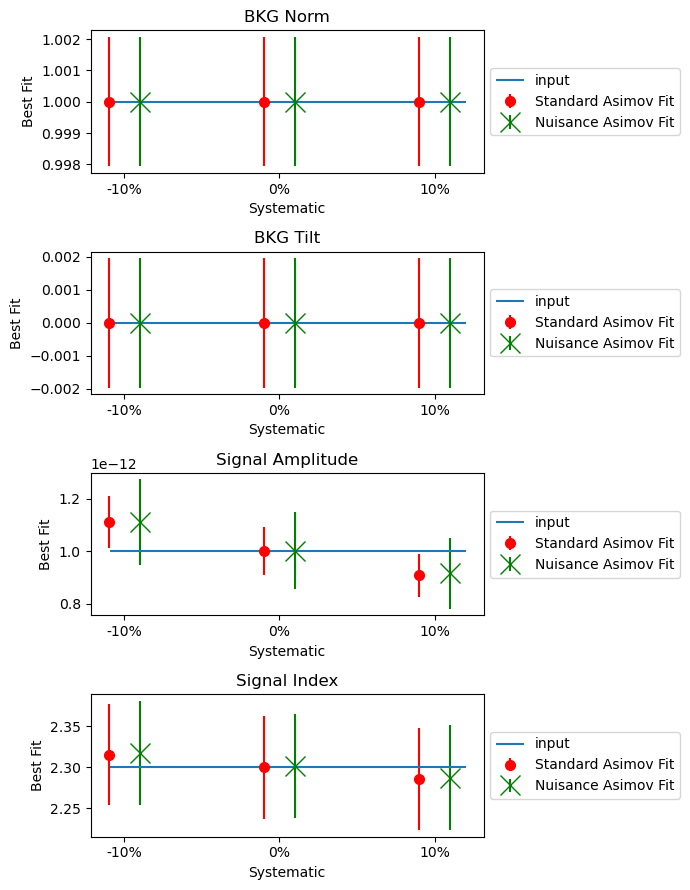

In [19]:
fig, axs = plt.subplots(4,1, figsize= (7, 9))

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(tilts[1:]):
    label = "Standard Asimov Fit"
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[3].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(tilts_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[3].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)

axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( tilts[0][0], 0.91, 3.2, label = "input")
axs[2].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")
axs[3].hlines( indices[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


### Spectrum

In [20]:
dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read("data/1_model_neg.yml")

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read("data/1_model_pos.yml")

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read("data/1_model_cor.yml")

In [21]:
for d in datasets:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True

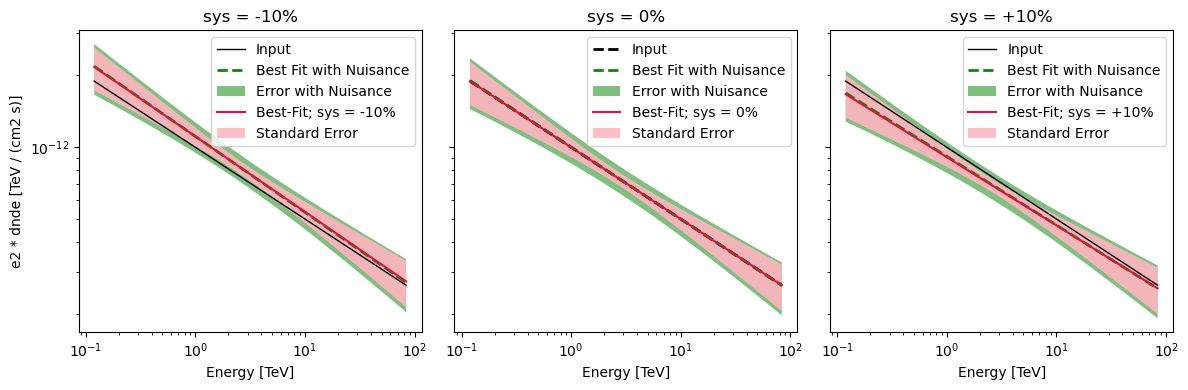

In [22]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### cor 
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.pdf")